In [1]:
#import modules
import pandas as pd
import warnings
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose as sd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DayLocator, DateFormatter
import os

In [2]:
#cwd id
cwd = os.getcwd()
files = os.listdir(cwd)
print("Files in % r: %s" % (cwd, files))

Files in 'c:\\Users\\jdfaz\\Documents\\LSE Python Assignment\\LSE_DA201_Assignment_files': ['.DS_Store', '.vscode', 'actual_duration.csv', 'appointments_regional.csv', 'H&F Waste Generation Dummy Data.ipynb', 'LSE_DA201_Assignment_Template.ipynb', 'metadata_nhs.txt', 'Module 6 Assignment.ipynb', 'national_categories.xlsx', 'NHS Python Script - Copy.ipynb', 'NHS Python Script.ipynb', 'tweets.csv']


In [3]:
#Function for getting the name of a Dataframe
def get_var_name(var):
    for name, value in globals().items():
        if value is var:
            return name

In [4]:
#Function to validate the data in a Dataframe
def validate_data(df):
    print(get_var_name(df),'\n')
    #check for unique values
    unique_counts = df.nunique()
    print("Unique values per column:")
    print(unique_counts)
    #snapshot the dataset
    print('\n',df.head(),'\n')
    #checking for duplicates
    duplicate_count = df.duplicated().sum()
    print("\nNumber of duplicate rows:")
    print(duplicate_count)

    #cross checking number of 
    df.info()
    
    #summary stats
    summary_stats = df.describe()
    print("\nSummary statistics:")
    print(summary_stats)
    
    return unique_counts, duplicate_count, summary_stats, print('\n')

In [5]:
def split_and_expand(df, columns, sep=','):
    for column in columns:
        # Split each specified column and create new columns for each part
        split_cols = df[column].str.split(sep, expand=True)
        split_cols.columns = [f"{column}_{i+1}" for i in range(split_cols.shape[1])]
        # Drop the original column and concatenate the new ones
        df = df.drop(columns=[column]).join(split_cols)
    return df

In [6]:
#Function to select columns and groupings in a Dataframe
def select_columns_and_group(df, columns_to_keep=None, group_by=None):
    """
    Select specified columns and group the DataFrame by specified columns.

    Parameters:
    df (pd.DataFrame): The DataFrame to filter and group.
    columns_to_keep (list): A list of column names to keep. If None, all columns are retained.
    group_by (list): A list of column names to group by. If None, no grouping is applied.

    Returns:
    pd.DataFrame: A new DataFrame with specified columns and grouping applied.
    """
    # Select specified columns
    if columns_to_keep is not None:
        # Ensure all specified columns exist in the DataFrame
        missing_columns = [col for col in columns_to_keep if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Columns not found in DataFrame: {missing_columns}")
        # Filter DataFrame to keep specified columns
        df = df[columns_to_keep]

    # Group DataFrame by specified columns
    if group_by is not None:
        # Ensure all specified grouping columns exist in the DataFrame
        missing_grouping_columns = [col for col in group_by if col not in df.columns]
        if missing_grouping_columns:
            raise ValueError(f"Grouping columns not found in DataFrame: {missing_grouping_columns}")
        # Group DataFrame by specified columns
        df = df.groupby(group_by).sum().reset_index()

    return df

In [7]:
#Function to convert to relevant columns to datetime
def convert_to_datetime(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                try:
                    df[col] = pd.to_datetime(df[col])
                except ValueError:
                    pass  # If conversion fails, continue to the next column
    return df

In [8]:
#Function to clean labels in any plot functions
def clean_label(label):
    return label.replace('_', ' ').title()

In [9]:
#Function to provide list for data sources as a dataframe when conducting analysis
"""
!!!Remember to add one for the twitter dataset!!!
"""
def header_list(df):
    df_list_ = df.copy()
    df_list = df_list_.columns.tolist()
    df_list = pd.DataFrame(df_list)
    new_header = df_list.iloc[0]  # Get the first row for the header
    df_list = df_list[1:]  # Take the data less the header row
    df_list.columns = new_header  # Set the header row as the df header
    df_list.reset_index(drop=True, inplace=True)  # Reset index
    return df_list


In [10]:
def filter_function(
        df,
        category=None,
        secondary_category=None,
        region=None,
        filt_values_keep=None,
        filt_values_out=None
    ):
    if category is not None:
        if filt_values_keep is not None and filt_values_out is None:
            df_filtered = df[df[category].isin(filt_values_keep)]
            df_filtered = df_filtered.dropna(axis=1, how='all').fillna(0).reset_index(drop=True)
            return df_filtered

        elif filt_values_out is not None  and filt_values_keep is None:
            if not isinstance(filt_values_out, list):  # Ensure filt_values_out is a list
                filt_values_out = [filt_values_out]
            df_filtered = df[~df[category].isin(filt_values_out)]
            df_filtered = df_filtered.dropna(axis=1, how='all').fillna(0).reset_index(drop=True)
            return df_filtered

        elif filt_values_out is not None and filt_values_keep is not None:
            df_filtered = df[df[category].isin(filt_values_keep)]
            if not isinstance(filt_values_out, list):  # Ensure filt_values_out is a list
                filt_values_out = [filt_values_out]
            df_filtered = df_filtered[~df_filtered[category].isin(filt_values_out)]
            df_filtered = df_filtered.dropna(axis=1, how='all').fillna(0).reset_index(drop=True)
            return df_filtered
        else:
            return df
    
    else:
        return df


In [11]:
#Pivot Chart Function
def plot_custom_pivot_chart(
    df,
    x_col, y_col, x_limits=None, y_limits=None, x_ticks=None, y_ticks=None, y_units='',
    l=10, h=6,
    title='Chart Title', chart_type='line',
    data_labels=False, separator='thousands',
    line_data_cols=None
):
    x_label = clean_label(x_col)
    y_label = clean_label(y_col)
    title = clean_label(title)

    sns.set(style="whitegrid")
    
    plt.figure(figsize=(l, h))
    ax = plt.gca()

    # Specify the date format
    date_format = f'%b %Y'

    # Create a duplicate of x_col for sorting and formatting
    df['x_col_copy'] = pd.to_datetime(df[x_col], format=date_format)

    # Parse the dates and sort by them
    df = df.copy().set_index('x_col_copy').sort_index()

    # Ensure that all columns except x_col are numeric
    numeric_df = df.drop(columns=[x_col]).apply(pd.to_numeric, errors='coerce')
    
    # Sort the values into the correct order for easy legend reading
    column_sums = numeric_df.sum()
    sorted_columns = column_sums.sort_values(ascending=False).index
    df_sorted = numeric_df[sorted_columns]

    # Specify chart_type and plot
    if chart_type == 'line':
        for col in df_sorted.columns:
            sns.lineplot(data=df_sorted, x=df_sorted.index, y=col, marker='o', label=clean_label(col))
        # Add line chart data
        if line_data_cols:
            for col in line_data_cols:
                sns.lineplot(data=df, x=df.index, y=col, marker='o', linestyle='dashed', color='black', label=clean_label(col + ' (Line)'))
    elif chart_type == 'stacked bar':
        df_sorted.plot(kind='bar', stacked=True, ax=ax)
    elif chart_type == 'clustered bar':
        df_sorted.plot(kind='bar', stacked=False, ax=ax)
    elif chart_type == 'stacked + line':
        df_sorted.plot(kind='bar', stacked=True, ax=ax)
        if line_data_cols is not None:
            for col in line_data_cols:
                sns.lineplot(data=df, x=df.index, y=col, marker='o', linestyle='dashed', color='black', label=clean_label(col + ' (Line)'))
    else:
        print('!Error! Invalid chart_type.\nSet chart_type = "line", "bar", or "stacked"')

    plt.title(title,fontsize=20)
    if x_label != 'Formatted Month':
        plt.xlabel(x_label,fontsize=16)
    else:
        plt.xlabel('')
    plt.ylabel(y_label,fontsize=16)
    plt.tight_layout()
    plt.legend(title=y_label, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Limits
    if x_limits is not None:
        ax.set_xlim(x_limits)
    if y_limits is not None:
        ax.set_ylim(y_limits)

    # x_tick Labels
    if (x_ticks == 'monthly' and chart_type == 'line'):
        ax.xaxis.set_major_locator(MonthLocator())
        ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
        plt.xticks(rotation=45, ha='right',fontsize=13)
    elif (x_ticks is not None and chart_type == 'stacked bar'):
        ax.set_xticks(range(len(df[x_col])))
        ax.set_xticklabels(df[x_col], rotation=45, ha='right', fontsize=13)

    # y_tick labels
    if y_ticks is not None:
        ax.set_yticks(y_ticks)
    
    # Apply y-axis units
    if y_units != '':
        if y_units == 'k':
            divisor = 1000
            y_label += ' (k)'
        elif y_units == 'M':
            divisor = 1000000
            y_label += ' (M)'
        else:
            divisor = 1
        
        def y_formatter(x, _):
            formatted_value = x / divisor
            if formatted_value.is_integer():
                return f'{formatted_value:.0f}{y_units}'
            else:
                return f'{formatted_value:.2f}{y_units}'
        
        ax.yaxis.set_major_formatter(plt.FuncFormatter(y_formatter))
    
    ax.tick_params(axis='y', labelsize=13)

    #Data Labels
    if data_labels:
        if chart_type == 'line':
            for line in ax.lines:
                for x, y in zip(line.get_xdata(), line.get_ydata()):
                    ax.text(x, y, f'{y:,.0f}', ha='center', va='bottom', fontsize=12, color='black', rotation=0)
        
        elif (chart_type == 'stacked bar' and separator == '%'):
            # Initialize a dictionary to store the total height for each x-axis category
            total_heights = {}
            for container in ax.containers:
                for patch in container:
                    x_value = patch.get_x()
                    # If the x-value is not in total_heights, initialize it with 0
                    if x_value not in total_heights:
                        total_heights[x_value] = 0
                    # Accumulate the height of the current bar to the total height of its category
                    total_heights[x_value] += patch.get_height()
            
            # Iterate over each container again to add percentage labels
            for container in ax.containers:
                for patch in container:
                    # Retrieve the total height for the category of the current bar
                    total_height = total_heights[patch.get_x()]
                    height = patch.get_height()
                    # Calculate the percentage based on the total height for the category
                    percentage = height / total_height * 100
                    
                    label = f'{percentage:.1f}%'
                    ax.text(patch.get_x() + patch.get_width() / 2, patch.get_y() + height / 2, label, ha='center', va='center', fontsize=14, color='black')
        
        elif chart_type in ['stacked bar', 'stacked + line']:
            for bar in ax.patches:
                height = bar.get_height()
                label_position = bar.get_y() + height / 2
                if separator == 'thousands':
                    label = f'{height:,.0f}'
                else:
                    label = f'{height:.0f}'
                ax.text(
                    bar.get_x() + bar.get_width() / 2, 
                    label_position, 
                    label, 
                    ha='center', 
                    va='center', 
                    fontsize=12, 
                    color='black'
                )
    
    plt.show()

In [12]:
# Function used to drop and pivot columns based on specified category and another function to plot a monthly chart based on certain parameters
def pivot_df_for_time_series(
        df,
        category=None,
        secondary_category=None,
        region=None
    ):
    # Changing the df_national_merged dataframe column Appointment Month to Formatted Month and assigning it as a new dataframe
    df_analysis = df.copy()
    df_analysis['formatted_month'] = df_analysis['appointment_month'].dt.strftime('%b %Y')
    df_analysis = df_analysis.drop(['appointment_month'], axis='columns')
    
    if category == 'sub_icb_location_name':
        df_analysis_global = select_columns_and_group(
            df_analysis.copy(),
            columns_to_keep = ['formatted_month', 'count_of_appointments', 'region_ons_code', category],
            group_by = ['formatted_month', 'region_ons_code', category]
        )
        pivot_df_analysis_global = df_analysis_global.copy().pivot_table(index=['formatted_month', 'region_ons_code'], columns=category, values='count_of_appointments', aggfunc='sum')
        pivot_df_analysis_global = pivot_df_analysis_global.reset_index()

    elif region is not None and category is not None:
        df_analysis_global = select_columns_and_group(
            df_analysis.copy(),
            columns_to_keep = ['formatted_month', 'count_of_appointments', 'region_ons_code', category],
            group_by = ['formatted_month', 'region_ons_code', category]
        )
        pivot_df_analysis_global = df_analysis_global.copy().pivot_table(index=['formatted_month', 'region_ons_code'], columns=category, values='count_of_appointments', aggfunc='sum')
        pivot_df_analysis_global = pivot_df_analysis_global.reset_index()
    
    elif category is None and region is not None:
        df_analysis_global = select_columns_and_group(
            df_analysis.copy(),
            columns_to_keep = ['formatted_month', 'count_of_appointments', 'region_ons_code'],
            group_by = ['formatted_month', 'region_ons_code']
        )
        pivot_df_analysis_global = df_analysis_global.copy().pivot_table(index=['formatted_month'], columns='region_ons_code', values='count_of_appointments', aggfunc='sum')
        pivot_df_analysis_global = pivot_df_analysis_global.reset_index()

    elif category is None:
        df_analysis_global = select_columns_and_group(
            df_analysis.copy(),
            columns_to_keep = ['formatted_month', 'count_of_appointments'],
            group_by = ['formatted_month']
        )
        pivot_df_analysis_global = df_analysis_global.copy()
        pivot_df_analysis_global = pivot_df_analysis_global.reset_index().drop(['index'], axis='columns')
    
    else:
        df_analysis_global = select_columns_and_group(
            df_analysis.copy(),
            columns_to_keep = ['formatted_month', 'count_of_appointments', category],
            group_by = ['formatted_month', category]
        )
        pivot_df_analysis_global = df_analysis_global.copy().pivot_table(index=['formatted_month'], columns=category, values='count_of_appointments', aggfunc='sum')
        pivot_df_analysis_global = pivot_df_analysis_global.reset_index()
    
    return pivot_df_analysis_global

def pivot_timeseries_chart(
    df,
    category=None,
    secondary_category=None,
    region=None,
    filt_values_keep=None,
    filt_values_out=None,
    chart_type='line',
    data_labels=False,
    title = 'Monthly Analysis of Appointments',
    l=17,
    h=10,
    seperator='%',
    x_units='', y_units=''
):
    print('!User Attention! - the following is a list of all the possible arguments and their defaults for this function:\ndf - must have a relevant dataframe\ncategory="None" - choose the category you want as your legend\nchart_type="line" - can also be set to "stacked bar"\ndata_labels=False - can also be set to True to activate data labels\ntitle = "Monthly Number of Appointments" - any str value\nl=17\nh=10\nseperator="%" - for data labels can also be set to "thousands"\ny_units='' - set this to the relevant units you want to see displayed i.e "k" or "M"\n')
    print('!User Attention! - if applicable use the following functions:\nprovide_category_lists("national_dataset") - to get a list of the headers for the national dataset\nor\nprovide_category_lists("region_ons_code") - to get a list of the NHS region code')
    df_pivot_result = pivot_df_for_time_series(
        df=df, 
        category=category, 
        secondary_category=secondary_category,
        region=region
    )

    
    df_pivot_result = filter_function(
        df_pivot_result,
        category=category, 
        secondary_category=secondary_category, 
        region=region,
        filt_values_keep=filt_values_keep,
        filt_values_out=filt_values_out
    )
    
    if category is not None:
        title = f'{title} by {category}'

    if region is not None and category is None:
    #    df_pivot_result = df_pivot_result.drop(['region_ons_code'], axis='columns')

        plot_custom_pivot_chart(
            df_pivot_result, 
            x_col='formatted_month', 
            y_col='Number of Appointments',
            x_ticks = 'monthly',
            y_ticks = None,
            y_units = y_units,
            chart_type = chart_type,
            data_labels = data_labels,
            title = f'{title} Region {region}',
            l = l,
            h = h,
            separator = seperator,
            line_data_cols=secondary_category
        )
    
    elif region is not None and category is not None:
        df_pivot_result = df_pivot_result.drop(['region_ons_code'], axis='columns')

        plot_custom_pivot_chart(
            df_pivot_result, 
            x_col='formatted_month', 
            y_col='Number of Appointments',
            x_ticks = 'monthly',
            y_ticks = None,
            y_units = y_units,
            chart_type = chart_type,
            data_labels = data_labels,
            title = f'{title} Region {region}',
            l = l,
            h = h,
            separator = seperator,
            line_data_cols=secondary_category
        )

    else:
        plot_custom_pivot_chart(
            df_pivot_result, 
            x_col='formatted_month', 
            y_col='Number of Appointments',
            x_ticks = 'monthly',
            y_ticks = None,
            y_units = y_units,
            chart_type = chart_type,
            data_labels = data_labels,
            title = f'{title}',
            l = l,
            h = h,
            separator = seperator,
            line_data_cols=secondary_category
        )

In [13]:
def simple_bar(df):
    plt.barh(df['hashtags'], df['constant'])
    plt.ylabel('Hashtags')
    plt.xlabel('Count')
    plt.title('Top 20 Hashtags')
    plt.tight_layout()

    #Add labels
    for i, v in enumerate(df['constant']):
        plt.text(v + 3, i, str(v), color='black', va='center')

    plt.show()

In [14]:
#importing data
df_daily_raw = pd.DataFrame(pd.read_csv('actual_duration.csv'))
df_daily = df_daily_raw.copy()
df_appointments_raw = pd.DataFrame(pd.read_csv('appointments_regional.csv'))
df_regional = df_appointments_raw.copy()
df_tweets_raw = pd.DataFrame(pd.read_csv('tweets.csv'))
df_tweets = df_tweets_raw.copy()
df_national_raw = pd.DataFrame(pd.read_excel('national_categories.xlsx'))
df_national = df_national_raw.copy()

In [15]:
#validating data
validate_data(df_daily)
validate_data(df_regional)
validate_data(df_national)
validate_data(df_tweets)

df_daily 

Unique values per column:
sub_icb_location_code         106
sub_icb_location_ons_code     106
sub_icb_location_name         106
icb_ons_code                   42
region_ons_code                 7
appointment_date              212
actual_duration                 7
count_of_appointments        7611
dtype: int64

   sub_icb_location_code sub_icb_location_ons_code  \
0                   00L                 E38000130   
1                   00L                 E38000130   
2                   00L                 E38000130   
3                   00L                 E38000130   
4                   00L                 E38000130   

                        sub_icb_location_name icb_ons_code region_ons_code  \
0  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
1  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
2  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
3  NHS North East and North Cumbria ICB - 00L

(tweet_id                   1174
 tweet_full_text             961
 tweet_entities              945
 tweet_entities_hashtags     710
 tweet_metadata                1
 tweet_retweet_count          47
 tweet_favorite_count         20
 tweet_favorited               1
 tweet_retweeted               1
 tweet_lang                    1
 dtype: int64,
 0,
            tweet_id  tweet_retweet_count  tweet_favorite_count
 count  1.174000e+03          1174.000000            1174.00000
 mean   1.567612e+18             8.629472               0.37138
 std    2.427553e+13            29.784675               2.04470
 min    1.567574e+18             0.000000               0.00000
 25%    1.567590e+18             0.000000               0.00000
 50%    1.567611e+18             1.000000               0.00000
 75%    1.567633e+18             3.000000               0.00000
 max    1.567655e+18           303.000000              42.00000,
 None)

In [16]:
df_tweets = df_tweets_raw.copy()
df_tweets = df_tweets.copy().drop(['tweet_full_text','tweet_entities','tweet_metadata','tweet_lang'], axis = 'columns')
columns_to_split = ['tweet_entities_hashtags']
df_tweets_expanded = split_and_expand(df_tweets,columns_to_split)
df_tweets_expanded

df_tweets_expanded = df_tweets_expanded.copy().drop(['tweet_retweet_count','tweet_favorite_count','tweet_favorited','tweet_retweeted'], axis='columns')
df_tweets_melted = pd.melt(df_tweets_expanded,id_vars=['tweet_id'], var_name='tweet_hashtags',value_name='hashtags')
df_tweets_melted['constant'] = 1
df_tweets_melted =select_columns_and_group(
    df_tweets_melted,
    columns_to_keep=['hashtags','constant'],
    group_by=['hashtags']
)
df_tweets_melted
df_tweets_sorted = df_tweets_melted.sort_values(by='constant', ascending=False)
df_tweets_sorted['hashtags'] = df_tweets_sorted['hashtags'].str.lower()
df_tweets_sorted = df_tweets_sorted.reset_index().drop(['index'], axis='columns')
df_tweets_sorted['hashtags'] = df_tweets_sorted['hashtags'].str.strip()
df_tweets_sorted = df_tweets_sorted.groupby(['hashtags']).sum().reset_index()
df_tweets_sorted = df_tweets_sorted.sort_values(by='constant', ascending=False).reset_index()
df_tweets_sorted = df_tweets_sorted.drop(['index'], axis='columns')
df_tweets_sorted = df_tweets_sorted.head(20).sort_values(by='constant', ascending=True)
df_tweets_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 19 to 0
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   hashtags  20 non-null     object
 1   constant  20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 480.0+ bytes


In [17]:
#transforming data

#transforming actual_duration dataset
df_daily_transform = convert_to_datetime(df_daily.copy().drop({'sub_icb_location_ons_code','sub_icb_location_code'},axis='columns'))
df_daily_transform['appointment_weekday'] = df_daily_transform['appointment_date'].dt.day_name()
df_daily_transform.rename(columns={'appointment_date': 'appointment_month'}, inplace=True)

#using df_daily to create a key legend for the other datasets that do not contain the region code
df_base_keylegend = df_daily_transform.copy().drop({'appointment_month','actual_duration','count_of_appointments'},axis='columns').drop_duplicates()
df_base_keylegend['icb_ons_location'] = df_base_keylegend['sub_icb_location_name'].str.split('-').str.get(0)

df_keylegend_icb_location = select_columns_and_group(
    df_base_keylegend.copy(),
    columns_to_keep = ['icb_ons_code', 'region_ons_code', 'icb_ons_location'],
    group_by = ['icb_ons_code' ,'region_ons_code']
)

df_keylegend = df_base_keylegend.copy().reset_index().drop(['index'],axis='columns')


#transforming appointments regional dataset
df_regional_transform = convert_to_datetime(df_regional.copy().drop_duplicates())
df_regional_merged = pd.merge(df_regional_transform, df_keylegend_icb_location, on=['icb_ons_code'], how='left')

#transforming national_categories dataset
df_national_transform = convert_to_datetime(df_national.copy())
df_national_merged = pd.merge(df_national_transform, df_keylegend, on=['sub_icb_location_name', 'icb_ons_code'], how='left')
df_national_merged['appointment_weekday'] = df_national_merged['appointment_date'].dt.day_name()

#transforming tweets dataset


#creating desired order list
df_daily_desired_order = ['region_ons_code', 'icb_ons_code', 'sub_icb_location_name', 'appointment_weekday','appointment_month', 'actual_duration', 'count_of_appointments']
df_keylegend_desired_order = ['region_ons_code', 'icb_ons_code', 'icb_ons_location', 'sub_icb_location_name']
df_regional_desired_order = ['region_ons_code','icb_ons_location', 'appointment_month', 'appointment_mode', 'appointment_status', 'hcp_type', 'time_between_book_and_appointment', 'count_of_appointments',]
df_national_desired_order = ['region_ons_code', 'icb_ons_location', 'sub_icb_location_name', 'service_setting', 'context_type', 'national_category', 'appointment_date', 'appointment_weekday', 'appointment_month', 'count_of_appointments']

#reordering columns
df_daily_transform = df_daily_transform[df_daily_desired_order]
df_keylegend = df_keylegend[df_keylegend_desired_order]
df_regional_merged = df_regional_merged[df_regional_desired_order]
df_national_merged = df_national_merged[df_national_desired_order]

DataFrame_List = ['df_daily_transform','df_regional_merged','df_national_merged','df_tweets_sorted']


In [18]:
#Function for ease of obtaining headers or necessary lists of specificed categories
#It is necessary to define here as I am referencing variables that have not yet been defined
def provide_category_lists(list_=None):
    if list_ == 'region_ons_code':
        region_list = df_keylegend_icb_location['region_ons_code'].drop_duplicates().reset_index().drop(['index'],axis='columns')
        region_list = region_list.sort_values(['region_ons_code']).reset_index().drop(['index'],axis='columns')
        
        return region_list

    elif list_ == 'regional_dataset':

        return header_list(df_regional_merged)

    elif list_ == 'duration_dataset':

        return header_list(df_daily_transform)
    
    elif list_ == 'national_dataset':
        df_national_merged_for_list = df_national_merged.copy().drop(['appointment_date', 'appointment_month', 'count_of_appointments'], axis='columns')
        
        return header_list(df_national_merged_for_list)
    
    elif list_ == None:
        print(f'Input a valid dataset argument:\nregion_ons_code - list of the NHS region code \nregional_dataset - list of the headers for the regional dataset\nduration_dataset - list of the headers for the duration dataset\nnational_dataset - list of the headers for the national dataset\nInput one of the above, wrapped in quotation marks.')

In [19]:
DataFrame_List

['df_daily_transform',
 'df_regional_merged',
 'df_national_merged',
 'df_tweets_sorted']

In [20]:
region_ons_code = provide_category_lists('region_ons_code')
regional_dataset_headers = provide_category_lists('regional_dataset')
duration_dataset_headers = provide_category_lists('duration_dataset')
national_dataset_headers = provide_category_lists('national_dataset')
regional_dataset_headers

,region_ons_code
0,icb_ons_location
1,appointment_month
2,appointment_mode
3,appointment_status
4,hcp_type
5,time_between_book_and_appointment
6,count_of_appointments


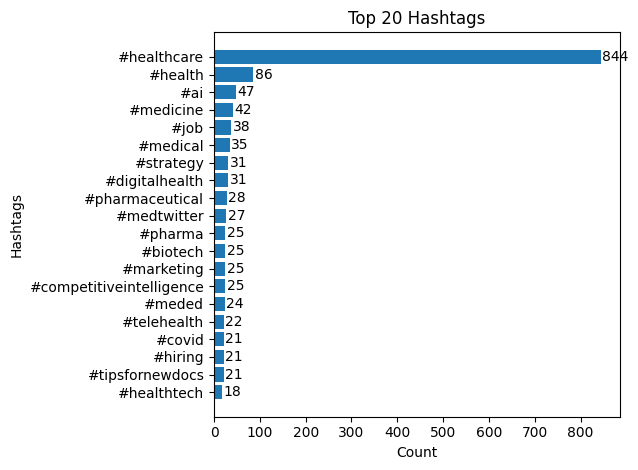

In [21]:
#twitter dataset visualisation
simple_bar(df_tweets_sorted)

!User Attention! - the following is a list of all the possible arguments and their defaults for this function:
df - must have a relevant dataframe
category="None" - choose the category you want as your legend
chart_type="line" - can also be set to "stacked bar"
data_labels=False - can also be set to True to activate data labels
title = "Monthly Number of Appointments" - any str value
l=17
h=10
seperator="%" - for data labels can also be set to "thousands"
y_units= - set this to the relevant units you want to see displayed i.e "k" or "M"

!User Attention! - if applicable use the following functions:
provide_category_lists("national_dataset") - to get a list of the headers for the national dataset
or
provide_category_lists("region_ons_code") - to get a list of the NHS region code


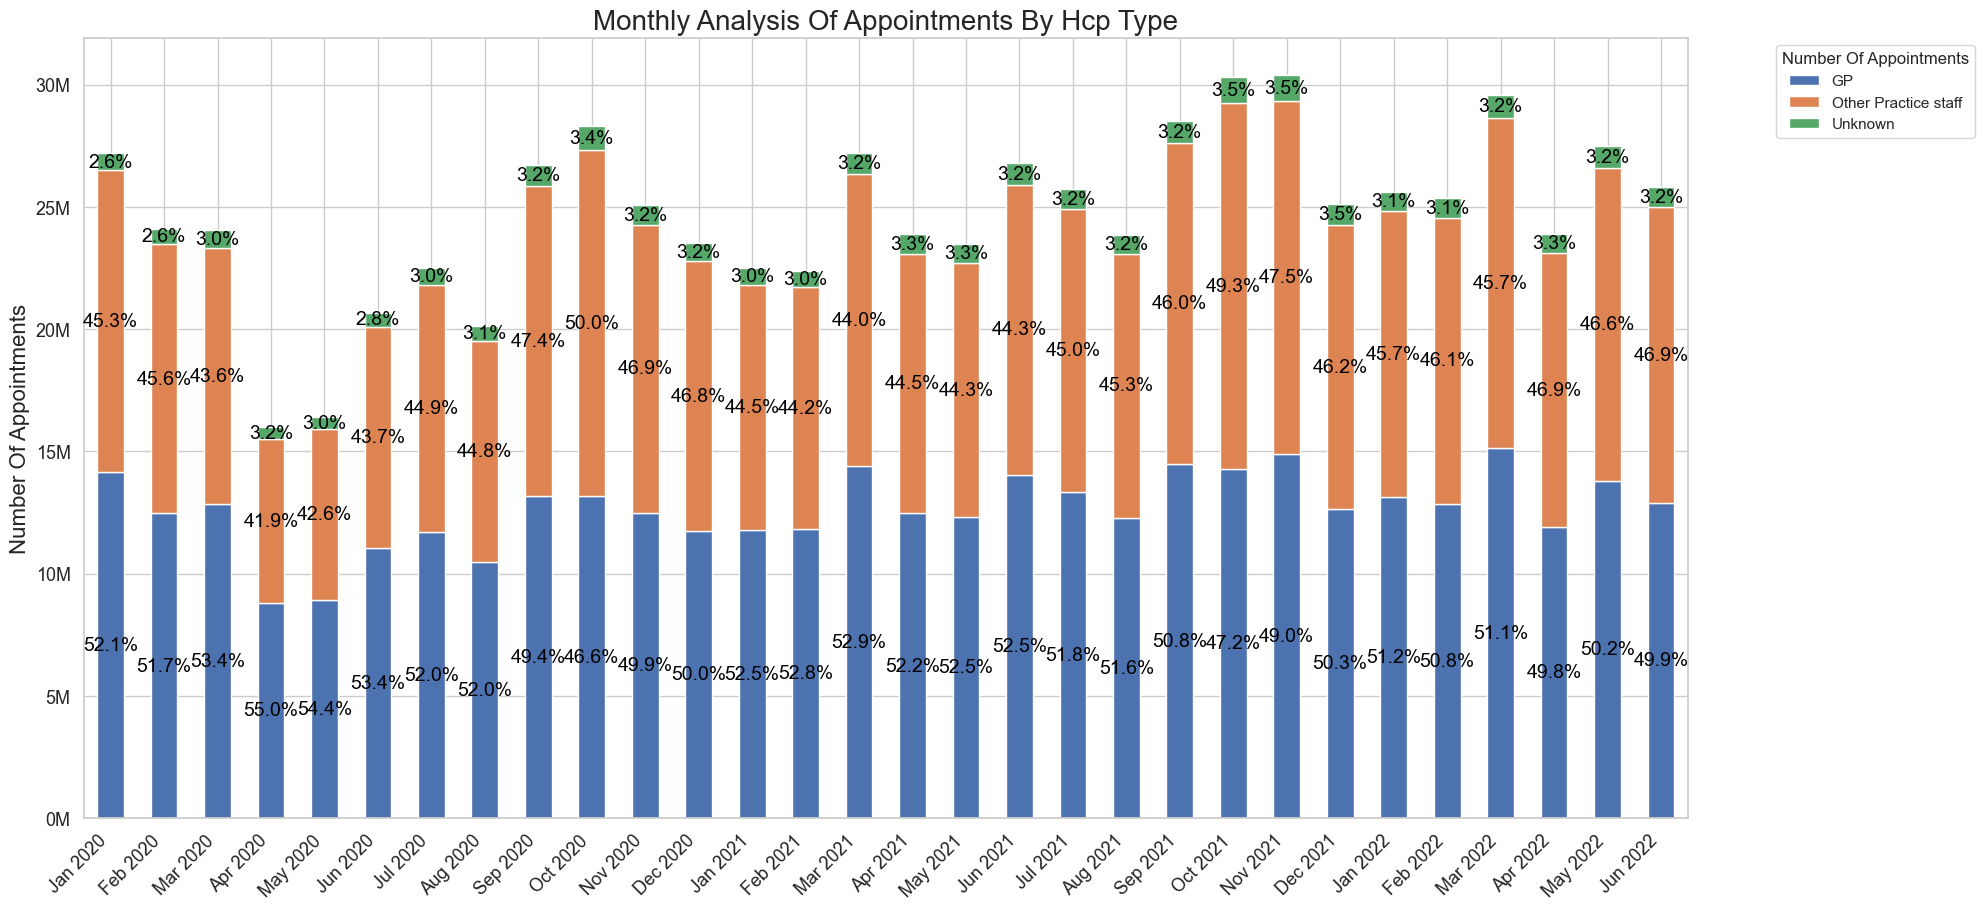

In [22]:
#ammend as necessary
#does not work with the twitter dataset
pivot_timeseries_chart(
    df_regional_merged,
    category='hcp_type',
    secondary_category=None,
    region=None,
    filt_values_keep=None,
    filt_values_out=None,
    chart_type='stacked bar',
    data_labels=True,
    title = 'Monthly Analysis of Appointments',
    l=17,
    h=10,
    seperator='%',
    x_units='', y_units='M'
)